# Galaxy Patch SNR Computation Notebook

This notebook demonstrates the entire process for computing the signal-to-noise ratio (SNR) for galaxy patches. In this workflow, the signal is defined as the patch itself, and the background is taken from an annulus defined by three radii. 

Each section explains the purpose and shows a placeholder image (which you can replace with actual figures of your output) along with the code.

## Step 1: Importing Libraries

In this step we import all the necessary libraries for image I/O, processing, and plotting.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.ndimage import label, center_of_mass
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import to_hex
import numpy.ma as ma
import math
from matplotlib.patches import Circle
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
# The notebook requires that you have the above libraries installed.

## Step 2: Load Galaxy Parameters

Here we load the galaxy parameters from a CSV file. These parameters include the file paths, distance (in Mpc), pixel scale, and the galaxy center. 

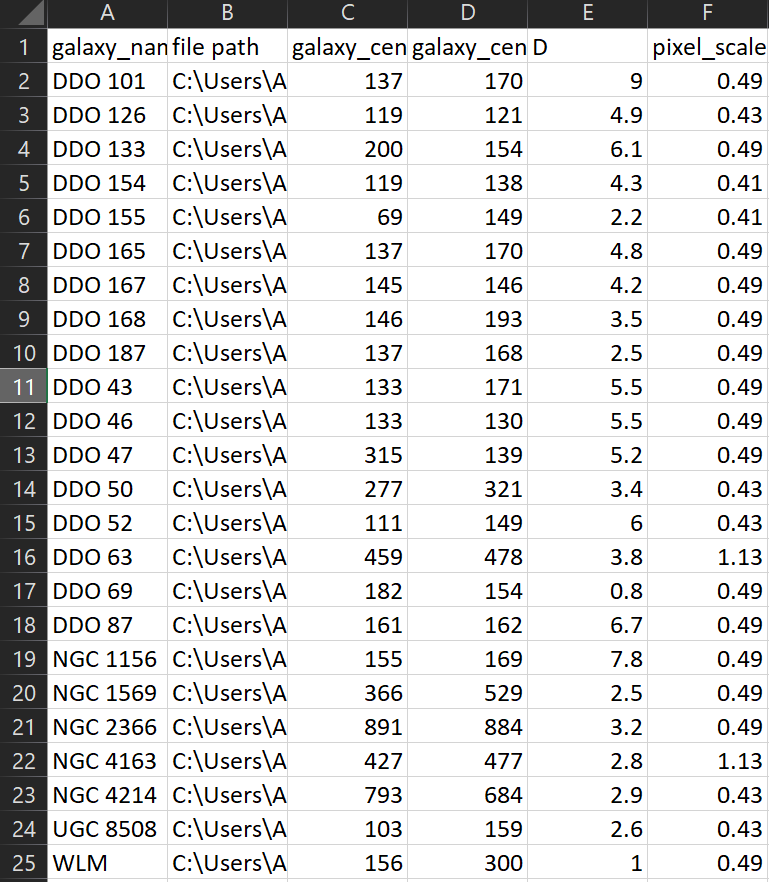

In [2]:
# Path to the CSV file containing galaxy parameters
csv_file_path = r"C:\Users\AYSAN\Desktop\project\Galaxy\H-alpha length\centers.csv"
num_farthest_patches = 10

def get_galaxy_data(galaxy_name, csv_file_path):
    df = pd.read_csv(csv_file_path)
    if galaxy_name not in df["galaxy_name"].values:
        raise ValueError(f"Galaxy '{galaxy_name}' not found in the dataset.")
    return df[df["galaxy_name"] == galaxy_name].iloc[0]

galaxy_name = input("Enter the galaxy name: ").strip()

try:
    galaxy_data = get_galaxy_data(galaxy_name, csv_file_path)
    fits_file_path = galaxy_data["file path"]
    D = galaxy_data["D"]               # Distance in Mpc
    pixel_scale = galaxy_data["pixel_scale"]
    galaxy_center_x = galaxy_data["galaxy_center_x"]
    galaxy_center_y = galaxy_data["galaxy_center_y"]
    D_pc = D * 1_000_000             # Convert Mpc to parsecs

    print(f"Galaxy: {galaxy_name}")
    print(f"FITS File Path: {fits_file_path}")
    print(f"Distance: {D} Mpc ({D_pc} parsecs)")
    print(f"Pixel Scale: {pixel_scale} arcsec/pixel")
    print(f"Galaxy Center: ({galaxy_center_x}, {galaxy_center_y})")
except ValueError as e:
    print(e)
    exit()
    
def log_scale_plot(image_data, plot_title, colorbar_title):
    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    im = ax.imshow(image_data, origin = "lower" , norm = norm)
    ax.set_title(plot_title)
    cbar = fig.colorbar(im)
    cbar.set_label(colorbar_title)
    plt.show()


Galaxy: DDO 69
FITS File Path: C:\Users\AYSAN\Desktop\project\Galaxy\H-alpha length\Cropped H-alpha\cropped_DDO 69_H.fits
Distance: 0.8 Mpc (800000.0 parsecs)
Pixel Scale: 0.49 arcsec/pixel
Galaxy Center: (182, 154)


## Step 3: Load and Filter the FITS Image

This section loads the FITS image, fixes the byte order (if needed), replaces bad values with 0, and applies a denoising filter. 


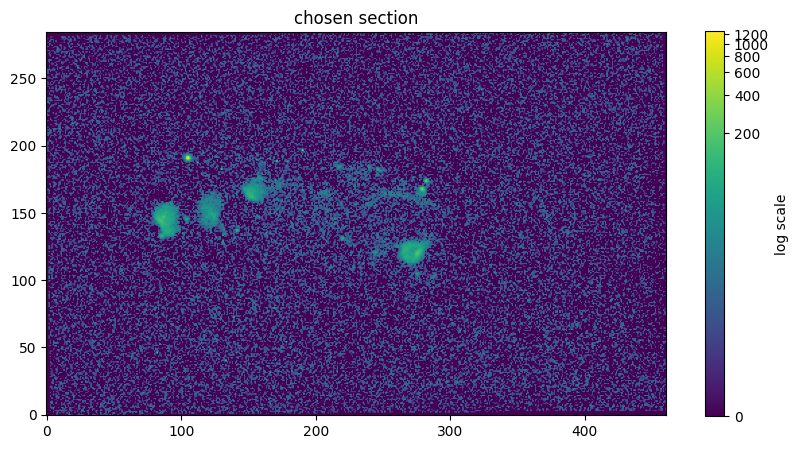

In [4]:
def load_fits_image(file_path):
    with fits.open(file_path) as hdul:
        image_data = hdul[0].data
        if image_data.dtype.byteorder == '>':
            image_data = image_data.byteswap().newbyteorder()
    return np.nan_to_num(image_data, nan=0.0, posinf=0.0, neginf=0.0)

image = load_fits_image(fits_file_path)
image_section = image
galaxy_center_x = galaxy_center_x 
galaxy_center_y = galaxy_center_y
log_scale_plot(image_section, "chosen section", "log scale")
# Estimate the noise level and apply non-local means filtering
sigma_est = np.mean(estimate_sigma(image_section, channel_axis=None))
filtered_image = denoise_nl_means(image_section, 
                                  h=1.15 * sigma_est, 
                                  fast_mode=True, 
                                  patch_size=5, 
                                  patch_distance=3, 
                                  channel_axis=None)

# Create a masked image: pixels with values below 4 become NaN
masked_image = np.where(filtered_image < 4, np.nan, filtered_image)

## Step 4: Identify Patches and Define the SNR Computation

We now identify connected patches in the masked image using a binary mask. In addition, we define a helper function `compute_patch_snr` which:

- Computes the patch center and the smallest circle (radius1) that encloses the patch (signal comes only from the patch itself).
- Defines radius2 and radius3 for the background annulus.
- Extracts the region of interest (ROI) covering the full circle defined by radius3.
- Computes the signal (mean over the patch pixels) and the background (median and standard deviation from the annulus), 
  and then calculates the SNR.

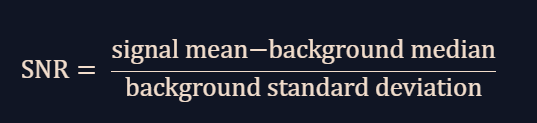
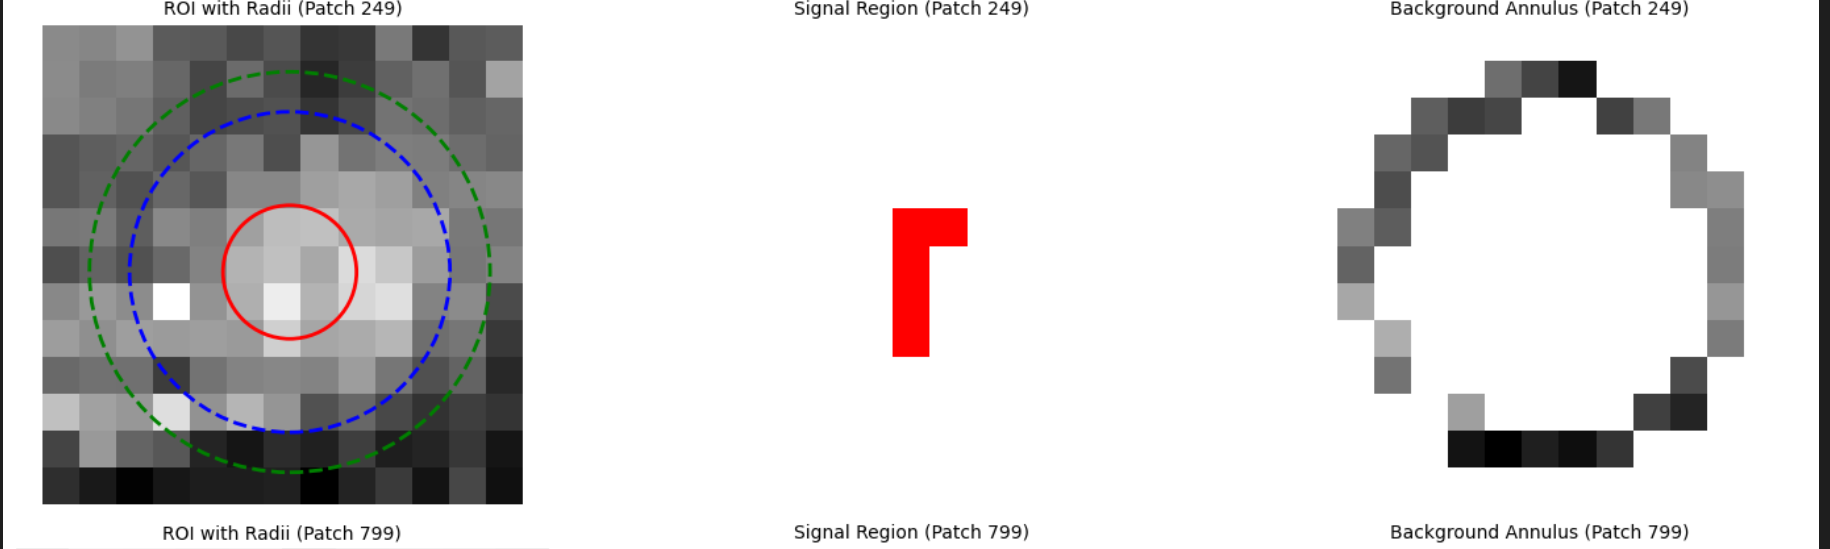


In [ ]:
import numpy as np
from scipy.ndimage import label
from scipy.spatial.distance import pdist

# Identify connected patches where pixels are not NaN
binary_mask = ~np.isnan(masked_image)
labeled_array, num_features = label(binary_mask)
unique_labels, counts = np.unique(labeled_array, return_counts=True)  # label 0 is background

def compute_patch_snr(filtered_image, patch_mask, sigma_est):
    """
    Given the filtered image and a binary patch_mask (True for patch pixels), this function computes:
      - The patch center (mean coordinate)
      - radius1: the smallest circle that encloses the patch (max distance from center to patch pixel)
      - radius2 (= 12/5 * radius1) and radius3 (= 3 * radius1) to define the background annulus
      - The ROI covering a circle of radius3 centered on the patch
      - The SNR as (signal_mean - background_median) / background_std, where the signal is the patch itself

    Modified: Only considers patches where the two farthest pixels are at least 6 pixels apart.
    """
    # Get coordinates of all True pixels
    coords = np.argwhere(patch_mask)
    if coords.size == 0:
        return None

    # Compute the maximum pairwise distance (patch "diameter").
    # For one pixel, max distance is zero.
    if coords.shape[0] > 1:
        patch_diameter = pdist(coords).max()
    else:
        patch_diameter = 0

    # Skip this patch if its diameter is less than 6 pixels
    if patch_diameter < 6:
        return None

    # Proceed with the original calculations
    # Compute patch center as the mean coordinate (y, x)
    patch_center = np.mean(coords, axis=0)
    
    # Compute distances from the patch center to each pixel and identify radius1.
    dists = np.sqrt(np.sum((coords - patch_center)**2, axis=1))
    radius1 = dists.max()

    # Define background annulus radii
    radius2 = radius1 * (12 / 5)
    radius3 = radius1 * 3

    # Determine the ROI boundaries for a circle of radius3 around the patch center
    y_center, x_center = patch_center
    y_min_roi = max(int(np.floor(y_center - radius3)), 0)
    y_max_roi = min(int(np.ceil(y_center + radius3)), filtered_image.shape[0] - 1)
    x_min_roi = max(int(np.floor(x_center - radius3)), 0)
    x_max_roi = min(int(np.ceil(x_center + radius3)), filtered_image.shape[1] - 1)
    roi = filtered_image[y_min_roi:y_max_roi+1, x_min_roi:x_max_roi+1]

    # Restrict the patch mask to the ROI
    patch_mask_roi = patch_mask[y_min_roi:y_max_roi+1, x_min_roi:x_max_roi+1]

    # Create a grid for the ROI
    y_indices = np.arange(y_min_roi, y_max_roi+1)
    x_indices = np.arange(x_min_roi, x_max_roi+1)
    Y, X = np.meshgrid(y_indices, x_indices, indexing='ij')
    dist_grid = np.sqrt((Y - y_center)**2 + (X - x_center)**2)

    # Define the background annulus as pixels with distances in (radius2, radius3]
    background_mask = (dist_grid > radius2) & (dist_grid <= radius3)

    # Signal is defined as the actual patch pixels (in the filtered image)
    signal_pixels = roi[patch_mask_roi]
    background_pixels = roi[background_mask]

    # Compute background statistics
    if background_pixels.size > 0:
        background_median = np.median(background_pixels)
        background_std = np.std(background_pixels)
    else:
        background_median = 0
        background_std = sigma_est

    signal_mean = np.mean(signal_pixels) if signal_pixels.size > 0 else np.nan
    snr = (signal_mean - background_median) / background_std if background_std > 0 else np.nan

    return {
        "snr": snr,
        "signal_mean": signal_mean,
        "background_median": background_median,
        "background_std": background_std,
        "patch_center": patch_center,
        "radius1": radius1,
        "radius2": radius2,
        "radius3": radius3,
        "roi": roi,
        "roi_coords": (y_min_roi, y_max_roi, x_min_roi, x_max_roi),
        "signal_mask": patch_mask_roi,  # signal defined as the actual patch pixels
        "background_mask": background_mask
    }


## Step 5: Loop Over Radii to Select Patches

We loop over candidate radii (in parsecs) to set a patch threshold. For each candidate, we compute the SNR for the top patches (farthest from the galaxy center) and select the first radius for which any patch has an SNR > 3.



## Step 6: Final Analysis and Creating the Patch Table

With the selected radius we now filter patches, compute distances, build a table of patch parameters and SNR values, and display a distribution plot over the image.




Top Patches Table (with SNR and Patch Diameter):
 Patch Number    SNR Distance (arcminutes) Distance (pc) Patch Diameter (px)
          545  2.684                 1.678       390.439               6.325
          616  3.119                 1.540       358.475               7.616
          191  2.360                 0.968       225.247               6.325
          370  1.996                 0.956       222.364               9.220
          373  0.244                 0.860       200.180               8.062
          307  4.286                 0.819       190.624               6.325
          264  2.834                 0.794       184.700               7.616
          504  1.410                 0.752       175.003              29.155
          404 10.254                 0.719       167.323              52.555
          842 53.441                 0.693       161.308               9.487


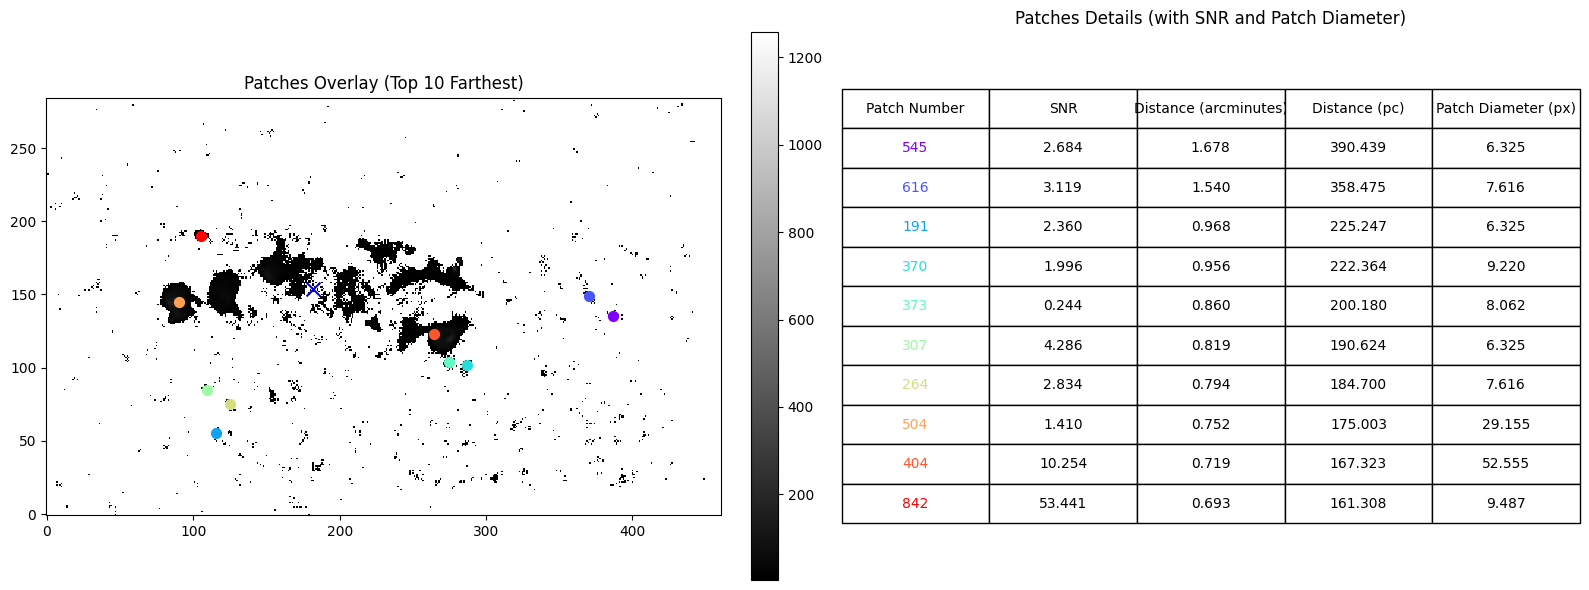

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import to_hex
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import pdist

def compute_patch_snr(filtered_image, patch_mask, sigma_est):
    """
    Given the filtered image and a binary patch_mask (True for patch pixels),
    this function computes:
      - The patch center (mean coordinate)
      - radius1: the smallest circle that encloses the patch (maximum distance from center to a patch pixel)
      - radius2 (= 12/5 * radius1) and radius3 (= 3 * radius1) to define the background annulus
      - The ROI covering a circle of radius3 centered on the patch
      - The SNR as (signal_mean - background_median) / background_std, where the signal is the patch itself

    Modified: Only considers patches where the maximum pairwise distance (patch diameter) is at least 6 pixels.
    The patch diameter is also returned for later display.
    """
    # Get coordinates of all True pixels for the patch.
    coords = np.argwhere(patch_mask)
    if coords.size == 0:
        return None

    # Compute the patch diameter as the maximum pairwise distance
    if coords.shape[0] > 1:
        patch_diameter = pdist(coords).max()
    else:
        patch_diameter = 0.0

    # Skip this patch if the farthest pixels aren't at least 6 pixels apart.
    if patch_diameter < 6:
        return None

    # Compute patch center as the mean coordinate (y, x).
    patch_center = np.mean(coords, axis=0)
    
    # Compute distances from the patch center and determine radius1.
    dists = np.sqrt(np.sum((coords - patch_center)**2, axis=1))
    radius1 = dists.max()

    # Define background annulus radii.
    radius2 = radius1 * (12 / 5)
    radius3 = radius1 * 3

    # Determine the ROI boundaries for a circle of radius3 around the patch center.
    y_center, x_center = patch_center
    y_min_roi = max(int(np.floor(y_center - radius3)), 0)
    y_max_roi = min(int(np.ceil(y_center + radius3)), filtered_image.shape[0] - 1)
    x_min_roi = max(int(np.floor(x_center - radius3)), 0)
    x_max_roi = min(int(np.ceil(x_center + radius3)), filtered_image.shape[1] - 1)
    roi = filtered_image[y_min_roi:y_max_roi+1, x_min_roi:x_max_roi+1]

    # Restrict the patch mask to the ROI.
    patch_mask_roi = patch_mask[y_min_roi:y_max_roi+1, x_min_roi:x_max_roi+1]

    # Create a grid for the ROI.
    y_indices = np.arange(y_min_roi, y_max_roi+1)
    x_indices = np.arange(x_min_roi, x_max_roi+1)
    Y, X = np.meshgrid(y_indices, x_indices, indexing='ij')
    dist_grid = np.sqrt((Y - y_center)**2 + (X - x_center)**2)

    # Define the background annulus (pixels in (radius2, radius3]).
    background_mask = (dist_grid > radius2) & (dist_grid <= radius3)

    # Signal is defined as the patch pixels in the filtered image.
    signal_pixels = roi[patch_mask_roi]
    background_pixels = roi[background_mask]

    # Compute background statistics.
    if background_pixels.size > 0:
        background_median = np.median(background_pixels)
        background_std = np.std(background_pixels)
    else:
        background_median = 0
        background_std = sigma_est

    signal_mean = np.mean(signal_pixels) if signal_pixels.size > 0 else np.nan
    snr = (signal_mean - background_median) / background_std if background_std > 0 else np.nan

    return {
        "snr": snr,
        "signal_mean": signal_mean,
        "background_median": background_median,
        "background_std": background_std,
        "patch_center": patch_center, 
        "radius1": radius1,
        "radius2": radius2,
        "radius3": radius3,
        "roi": roi,
        "roi_coords": (y_min_roi, y_max_roi, x_min_roi, x_max_roi),
        "signal_mask": patch_mask_roi,  # Signal defined as the patch pixels.
        "background_mask": background_mask,
        "patch_diameter": patch_diameter  # New: store the patch diameter.
    }

# --------------------------------------------------------------------
# Here we work directly with the connected patches from your labeled image.
# --------------------------------------------------------------------

# Assume these variables are defined elsewhere:
# - masked_image: the input image with NaN values.
# - filtered_image: the image used in SNR calculation.
# - sigma_est: estimated sigma for the background.
# - D_pc: distance in parsecs.
# - pixel_scale: conversion factor from pixels to arcseconds.
# - galaxy_center_x, galaxy_center_y: the coordinates of the galaxy center.
# - num_farthest_patches: number of top patches to display.

# Pre-computed connected components:
binary_mask = ~np.isnan(masked_image)
labeled_array, num_features = label(binary_mask)
unique_labels, counts = np.unique(labeled_array, return_counts=True)  # Label 0 is background.

patch_snr_results = {}
patch_centers = {}

# Loop over each patch (skipping background label 0) and compute SNR.
for lbl in unique_labels:
    if lbl == 0:
        continue  # Skip background.
    patch_mask = (labeled_array == lbl)
    result = compute_patch_snr(filtered_image, patch_mask, sigma_est)
    if result is None:
        continue  # This patch did not meet the width criterion.
    patch_snr_results[lbl] = result
    patch_centers[lbl] = result["patch_center"]

if not patch_snr_results:
    print("No valid patches found based on the width requirement.")
    raise ValueError("No valid patches found.")

# Calculate distances from the galaxy center.
distances = {lbl: np.linalg.norm(np.array(center) - np.array([galaxy_center_y, galaxy_center_x]))
             for lbl, center in patch_centers.items()}

# Sort patches by distance (largest first) and select the top patches.
sorted_patches = sorted(distances.items(), key=lambda x: x[1], reverse=True)
top_sorted_patches = sorted_patches[:num_farthest_patches]

# --------------------------------------------------------------------
# Build the results table, adding a new column for patch diameter.
# --------------------------------------------------------------------
table_data = []
for lbl, dist_px in top_sorted_patches:
    result = patch_snr_results[lbl]
    snr_val = result["snr"]
    patch_diameter = result["patch_diameter"]
    # Convert distances: pixels to arcseconds, arcminutes, and parsecs.
    dist_arcsec = dist_px * pixel_scale
    dist_arcmin = dist_arcsec / 60
    dist_pc = (dist_arcsec / 206265) * D_pc
    table_data.append([lbl, snr_val, dist_px, dist_arcmin, dist_pc, patch_diameter])

columns = [
    "Patch Number", "SNR", "Distance (px)", "Distance (arcminutes)",
    "Distance (pc)", "Patch Diameter (px)"
]
patch_table = pd.DataFrame(table_data, columns=columns)
# Remove the "Distance (px)" column from both the columns list and the DataFrame
columns.remove("Distance (px)")
patch_table = patch_table.drop(columns=["Distance (px)"])
# Format the numeric columns for readability.
for col in ["SNR", "Distance (arcminutes)", "Distance (pc)", "Patch Diameter (px)"]:
    patch_table[col] = patch_table[col].apply(lambda x: f"{x:.3f}" if np.isfinite(x) else "NaN")

print("\nTop Patches Table (with SNR and Patch Diameter):")
print(patch_table.to_string(index=False))

# --------------------------------------------------------------------
# Visualization: overlay patches on image and show results table.
# --------------------------------------------------------------------
colors = cm.rainbow(np.linspace(0, 1, len(top_sorted_patches)))
hex_colors = [to_hex(c) for c in colors]

fig, (ax_image, ax_table_plot) = plt.subplots(1, 2, figsize=(16, 6))
im = ax_image.imshow(masked_image, cmap="gray", origin="lower", interpolation="nearest")
ax_image.scatter(galaxy_center_x, galaxy_center_y, color="blue", marker="x", s=100)
for idx, (lbl, _) in enumerate(top_sorted_patches):
    center_y, center_x = patch_centers[lbl]
    ax_image.scatter(center_x, center_y, color=hex_colors[idx], s=50)
ax_image.set_title(f"Patches Overlay (Top {num_farthest_patches} Farthest)")
fig.colorbar(im, ax=ax_image, fraction=0.046, pad=0.04)

ax_table_plot.axis("tight")
ax_table_plot.axis("off")
table_plot = ax_table_plot.table(cellText=patch_table.values, colLabels=columns,
                                 loc="center", cellLoc="center")
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)
table_plot.scale(1, 2)
for i in range(len(patch_table)):
    cell = table_plot[(i+1, 0)]
    cell.get_text().set_color(hex_colors[i])
ax_table_plot.set_title("Patches Details (with SNR and Patch Diameter)")
plt.tight_layout()
plt.show()


## Step 7: Visualize the ROI, Signal, and Background Annulus

For each top patch, we visualize three panels:

- **Left:** The ROI with three overlaid circles (red: radius1, blue dashed: radius2, green dashed: radius3).
- **Middle:** The signal region view (actual patch pixels).
- **Right:** The background annulus view (only pixels from the annulus).



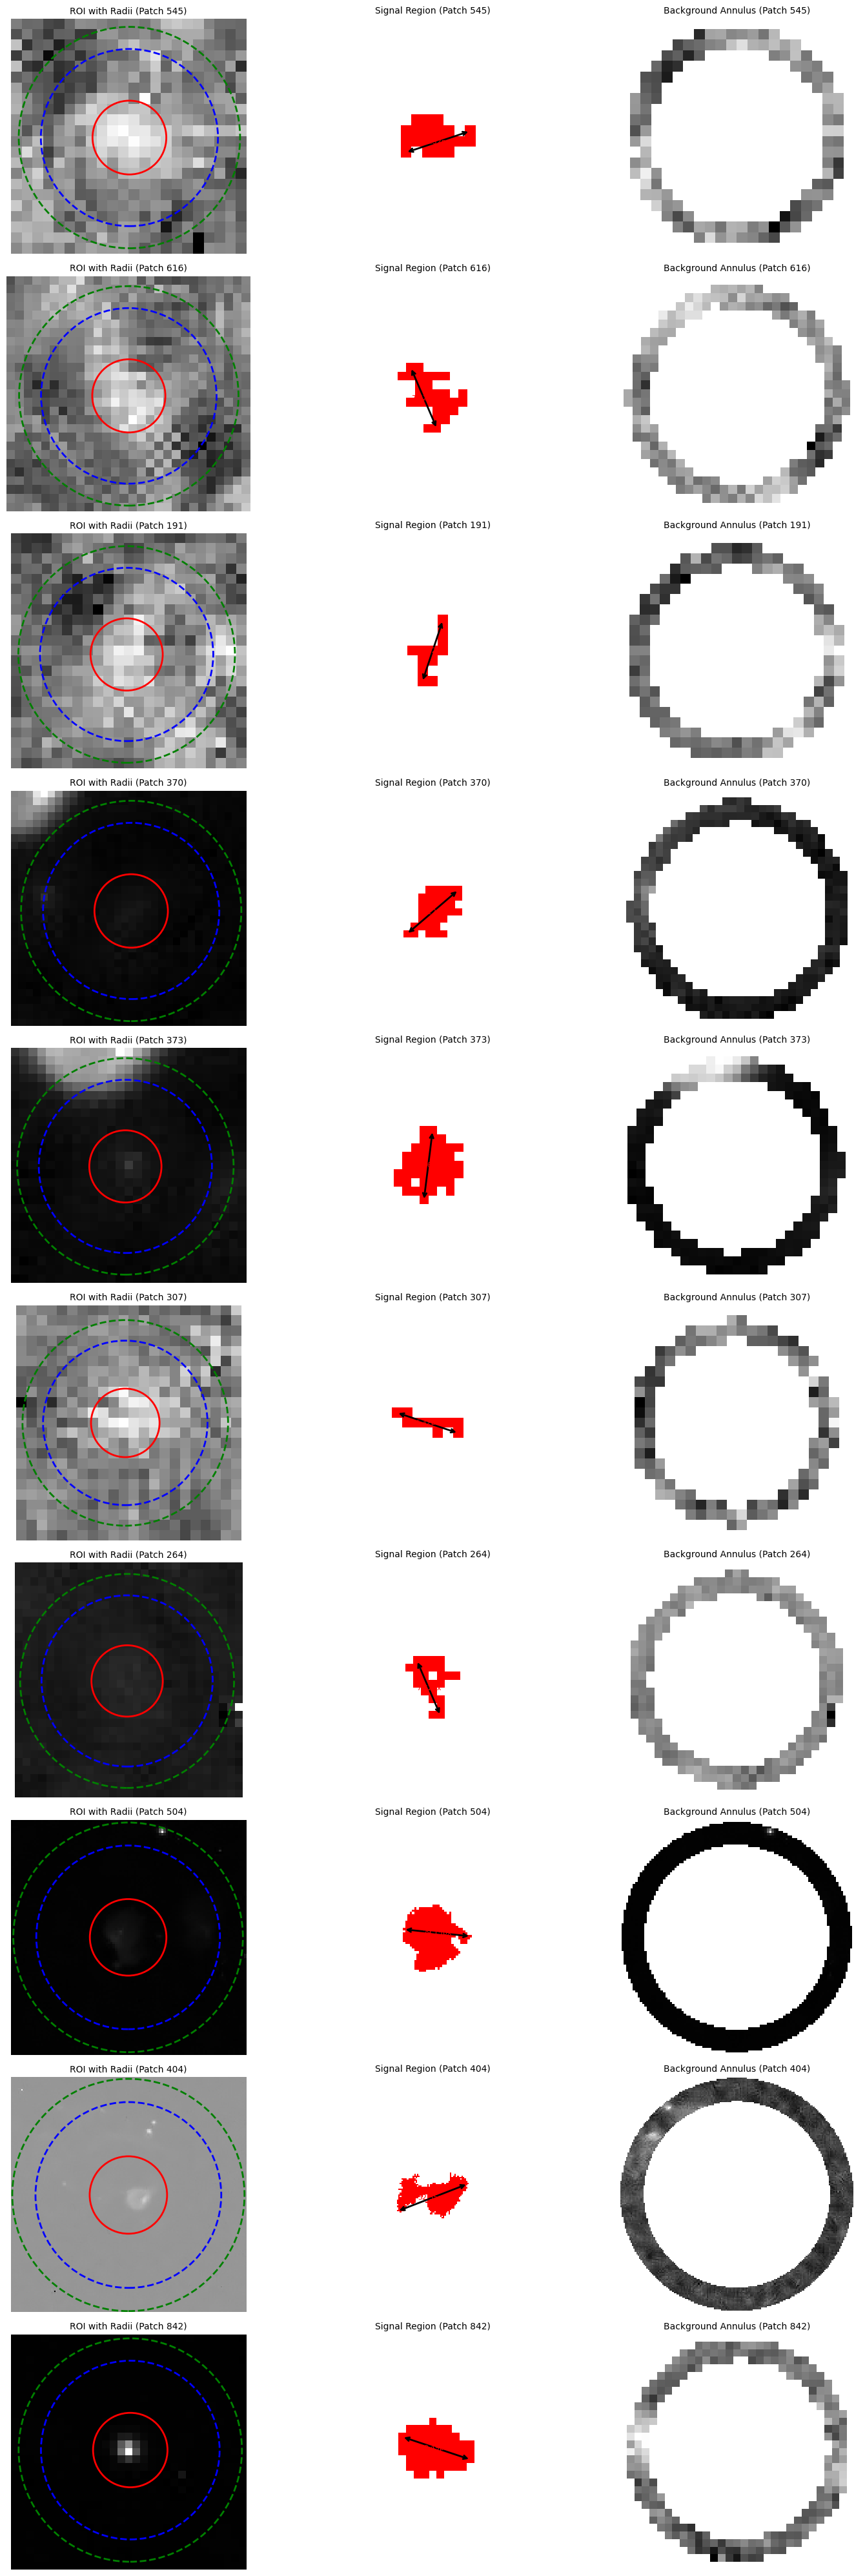

In [13]:
from matplotlib.patches import Circle
import numpy.ma as ma
from scipy.spatial.distance import pdist, squareform

# Use the top sorted patches computed earlier.
num_top_visualize = len(top_sorted_patches)
fig, axes = plt.subplots(num_top_visualize, 3, figsize=(15, 4 * num_top_visualize))
if num_top_visualize == 1:
    axes = np.array([axes])

for i, (lbl, _) in enumerate(top_sorted_patches):
    # Get the precomputed patch results.
    result = patch_snr_results[lbl]
    
    roi = result["roi"]
    y_min_roi, y_max_roi, x_min_roi, x_max_roi = result["roi_coords"]
    signal_mask = result["signal_mask"]
    background_mask = result["background_mask"]
    patch_center = result["patch_center"]
    radius1 = result["radius1"]
    radius2 = result["radius2"]
    radius3 = result["radius3"]
    
    # Left Panel: ROI with the three circles (the patch and background regions).
    ax_roi = axes[i, 0]
    ax_roi.imshow(roi, cmap="gray", origin="lower", interpolation="nearest")
    # Adjust the patch center to the ROI coordinate system.
    center_ROI = (patch_center[1] - x_min_roi, patch_center[0] - y_min_roi)
    circle1 = Circle(center_ROI, radius1, edgecolor="red", facecolor="none", linewidth=2)
    circle2 = Circle(center_ROI, radius2, edgecolor="blue", facecolor="none", linestyle="dashed", linewidth=2)
    circle3 = Circle(center_ROI, radius3, edgecolor="green", facecolor="none", linestyle="dashed", linewidth=2)
    ax_roi.add_patch(circle1)
    ax_roi.add_patch(circle2)
    ax_roi.add_patch(circle3)
    ax_roi.set_title(f"ROI with Radii (Patch {lbl})", fontsize=10)
    ax_roi.axis("off")

    # Middle Panel: Signal region view (patch-only view, where patch pixels are highlighted in red).
    ax_patch_view = axes[i, 1]
    patch_only = np.ones((roi.shape[0], roi.shape[1], 3))
    patch_only[signal_mask] = [1, 0, 0]   # patch pixels in red
    ax_patch_view.imshow(patch_only, origin="lower", interpolation="nearest")
    
    # Compute the patch's diameter endpoints using the ROI-restricted patch mask.
    coords_roi = np.argwhere(signal_mask)
    if coords_roi.shape[0] > 1:
        # Compute all pairwise distances.
        dmat = squareform(pdist(coords_roi))
        # Find the indices where the distance is the maximum.
        idx = np.unravel_index(np.argmax(dmat), dmat.shape)
        endpoint1_roi = coords_roi[idx[0]]
        endpoint2_roi = coords_roi[idx[1]]
        
        # Draw a double-sided arrow between the two endpoints.
        ax_patch_view.annotate('',
                               xy=(endpoint2_roi[1], endpoint2_roi[0]),
                               xytext=(endpoint1_roi[1], endpoint1_roi[0]),
                               arrowprops=dict(arrowstyle='<->', color='black', lw=2))
        # Annotate the arrow with the patch diameter (in pixels).
        mid_x = (endpoint1_roi[1] + endpoint2_roi[1]) / 2
        mid_y = (endpoint1_roi[0] + endpoint2_roi[0]) / 2
        ax_patch_view.text(mid_x, mid_y, f"{result['patch_diameter']:.2f}px",
                           color='red', fontsize=8, ha='center', va='center')
    
    ax_patch_view.set_title(f"Signal Region (Patch {lbl})", fontsize=10)
    ax_patch_view.axis("off")

    # Right Panel: Background annulus view.
    ax_bg_view = axes[i, 2]
    background_view = ma.masked_where(~background_mask, roi)
    cmap_bg = plt.cm.gray.copy()
    cmap_bg.set_bad(color="white")
    ax_bg_view.imshow(background_view, cmap=cmap_bg, origin="lower", interpolation="nearest")
    ax_bg_view.set_title(f"Background Annulus (Patch {lbl})", fontsize=10)
    ax_bg_view.axis("off")

plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrated how to compute the SNR of galaxy patches by taking the patch (signal) and comparing it to a defined background annulus. Each step was explained with details and placeholder images are provided for illustration. Feel free to replace the placeholder images with actual screenshots from your outputs.